# Import packages:


In [1]:
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.stats import kurtosis, skew

# Helper functions:


In [2]:
def add_total_production_area(
    input_data: pd.DataFrame, rainfed_prod_col: str, irrigated_prod_col: str
) -> pd.DataFrame:
    return input_data.assign(
        total_production_area=input_data[rainfed_prod_col]
        + input_data[irrigated_prod_col]
    )


def add_production_area_percentage(
    input_data: pd.DataFrame,
    total_plantation_area_col: str,
    total_production_area_col: str,
) -> pd.DataFrame:
    return input_data.assign(
        production_area_percentage=(
            input_data[total_production_area_col]
            / input_data[total_plantation_area_col]
        )
        * 100.0
    )


def add_rainfed_production_area_percentage(
    input_data: pd.DataFrame,
    rainfed_production_area_col: str,
    total_production_area_col: str,
) -> pd.DataFrame:
    return input_data.assign(
        rainfed_production_area_percentage=(
            input_data[rainfed_production_area_col]
            / input_data[total_production_area_col]
        )
        * 100.0
    )


def add_rainfed_total_production(
    input_data: pd.DataFrame, rainfed_production_area_col: str, rainfed_yield_col: str
) -> pd.DataFrame:
    return input_data.assign(
        rainfed_total_production=(
            input_data[rainfed_production_area_col] * input_data[rainfed_yield_col]
        )
        / 1000.0
    )


def add_irrigated_total_production(
    input_data: pd.DataFrame,
    irrigated_production_area_col: str,
    irrigated_yield_col: str,
) -> pd.DataFrame:
    return input_data.assign(
        irrigated_total_production=(
            input_data[irrigated_production_area_col] * input_data[irrigated_yield_col]
        )
        / 1000.0
    )

# Load data:


In [3]:
terra_climate_df = pd.read_parquet(
    "../data/processed/terra_climate/terra_climate_monthly_data.parquet"
)

In [4]:
aemet_monthly_df = pd.read_parquet("../data/processed/aemet/aemet_monthly_data.parquet")

In [5]:
olive_yield_df = pd.read_parquet("../data/processed/olive_yield/olive_yield.parquet")

In [6]:
olive_cultivation_system_df = pd.read_parquet(
    "../data/processed/olive_cultivation_system/olive_cultivation_system.parquet"
)

In [7]:
terra_climate_df["date"] = pd.to_datetime(terra_climate_df["date"])

In [8]:
spain_map = gpd.read_file("../data/processed/maps/")

# EDA:


## 1. Total Olive Yield Over Time


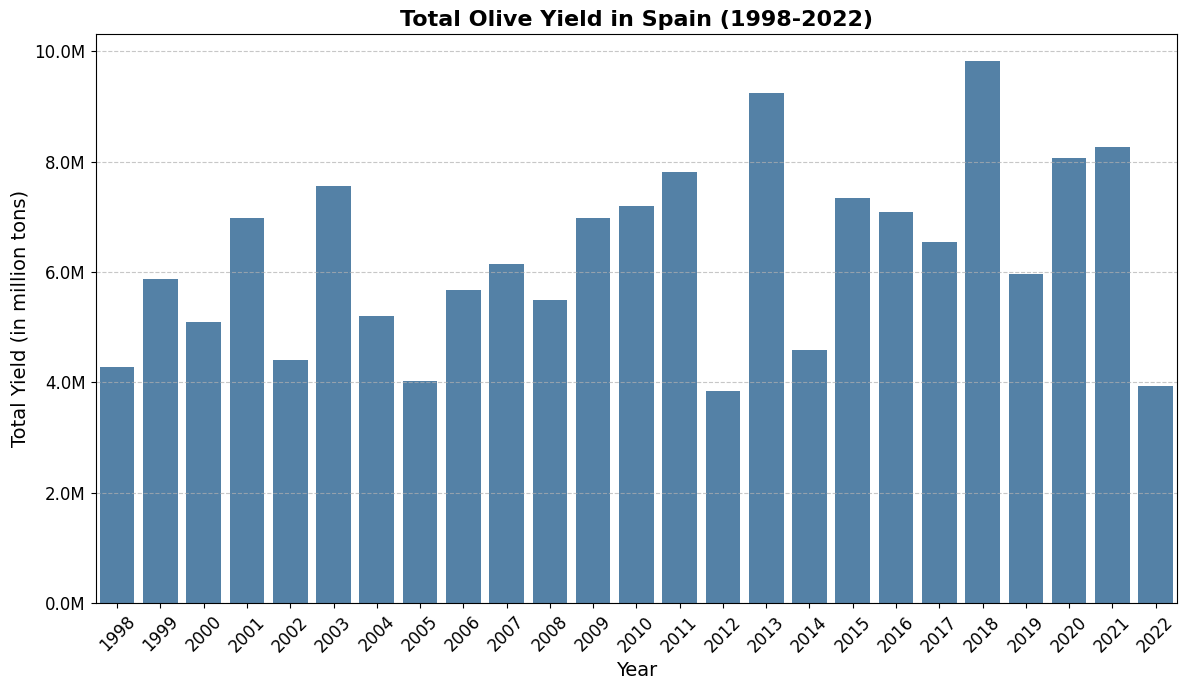

In [9]:
plt.figure(figsize=(12, 7))

# Group the total olive yield per year
yearly_total_yield = olive_yield_df.groupby("year")["total"].sum().reset_index()

# Create the bar plot
sns.barplot(x="year", y="total", data=yearly_total_yield, color="steelblue")

# Add title and labels
plt.title("Total Olive Yield in Spain (1998-2022)", fontsize=16, weight="bold")
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Yield (in million tons)", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Format y-axis to display in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x*1e-6:.1f}M"))

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## 2. Comparison of Olive Oil vs. Table Olive Yield Over Time


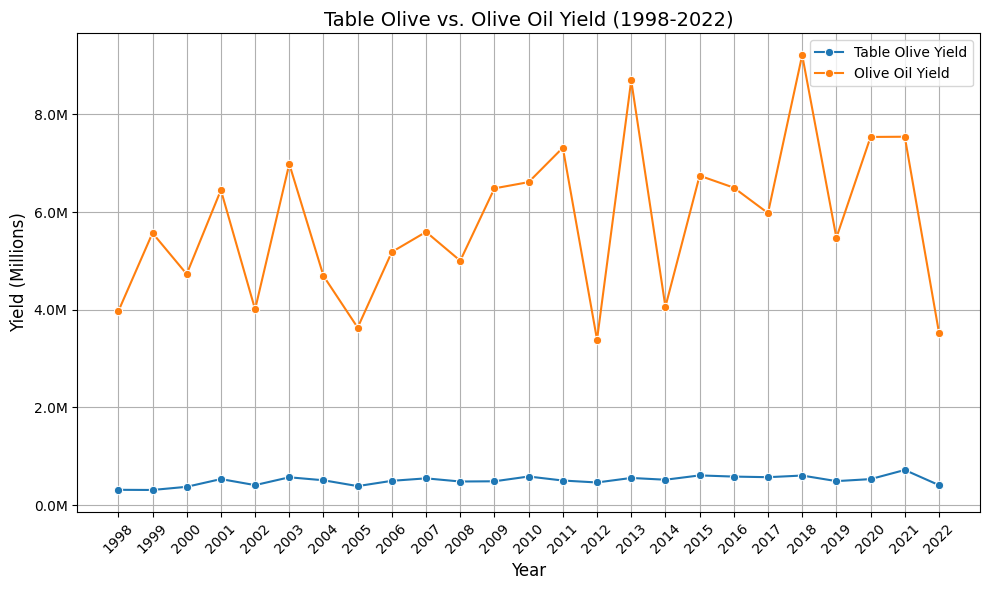

In [10]:
plt.figure(figsize=(10, 6))
yearly_yield_breakdown = (
    olive_yield_df.groupby("year")[["table_olive", "olive_oil"]].sum().reset_index()
)

sns.lineplot(
    x="year",
    y="table_olive",
    data=yearly_yield_breakdown,
    label="Table Olive Yield",
    marker="o",
)
sns.lineplot(
    x="year",
    y="olive_oil",
    data=yearly_yield_breakdown,
    label="Olive Oil Yield",
    marker="o",
)

# Adding a custom formatter to display the y-axis in millions (e.g., 1M, 2M)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x*1e-6:.1f}M"))

# Setting all years as xticks
years = yearly_yield_breakdown["year"].tolist()  # Get a list of all the years
plt.xticks(
    ticks=years, rotation=45
)  # Set all years as xticks and rotate labels for readability

plt.title("Table Olive vs. Olive Oil Yield (1998-2022)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yield (Millions)", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()  # Adjusts the plot to fit well in the figure
plt.show()

## 3. Top 10 Olive producing provinces:


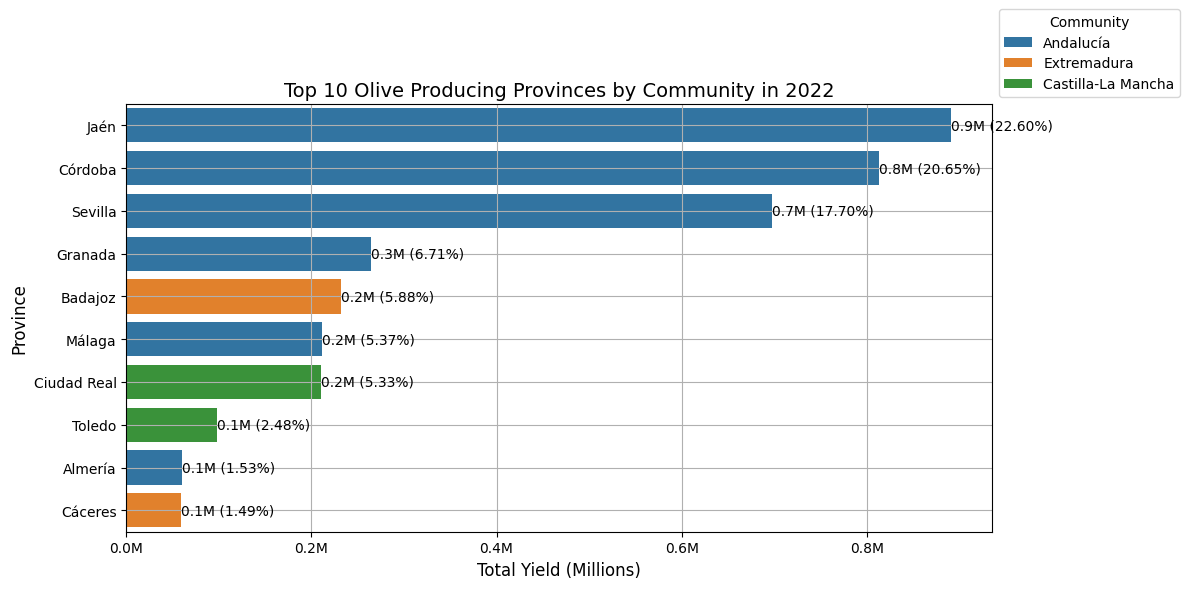

In [11]:
# Specify the year you want to focus on
year_of_interest = 2022  # Change this to any other year you want to focus on

# Filter the data for the specific year
yearly_data = olive_yield_df[olive_yield_df["year"] == year_of_interest]

# Calculate total yield and percentage contribution for that year
total_yield_year = yearly_data["total"].sum()
top_provinces_year = (
    yearly_data.groupby("province")["total"]
    .sum()
    .reset_index()
    .sort_values(by="total", ascending=False)
    .head(10)
    .merge(spain_map[["community", "province"]], on="province")
)

top_provinces_year["percentage"] = (
    top_provinces_year["total"] / total_yield_year
) * 100  # Calculate percentage contribution

# Use gradient coloring based on total yield
# Let's color by community to visually show which provinces belong to which community
colors = sns.color_palette("tab10", len(top_provinces_year["community"].unique()))
community_colors = dict(zip(top_provinces_year["community"].unique(), colors))

# Plot the top provinces for the chosen year
plt.figure(figsize=(12, 6))
sns.barplot(
    x="total",
    y="province",
    data=top_provinces_year,
    hue="community",
    palette=community_colors,
)

# Add the total and percentage values as text labels
for index, value in enumerate(top_provinces_year["total"]):
    plt.text(
        value,
        index,
        f"{value/1e6:.1f}M ({top_provinces_year['percentage'].iloc[index]:.2f}%)",  # Display yield in millions
        va="center",
    )

# Format x-axis to display values in millions
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x*1e-6:.1f}M"))

plt.title(
    f"Top 10 Olive Producing Provinces by Community in {year_of_interest}", fontsize=14
)
plt.xlabel("Total Yield (Millions)", fontsize=12)
plt.ylabel("Province", fontsize=12)
plt.legend(title="Community", bbox_to_anchor=(1, 1))  # Move legend to the side
plt.grid(True)
plt.tight_layout()
plt.show()

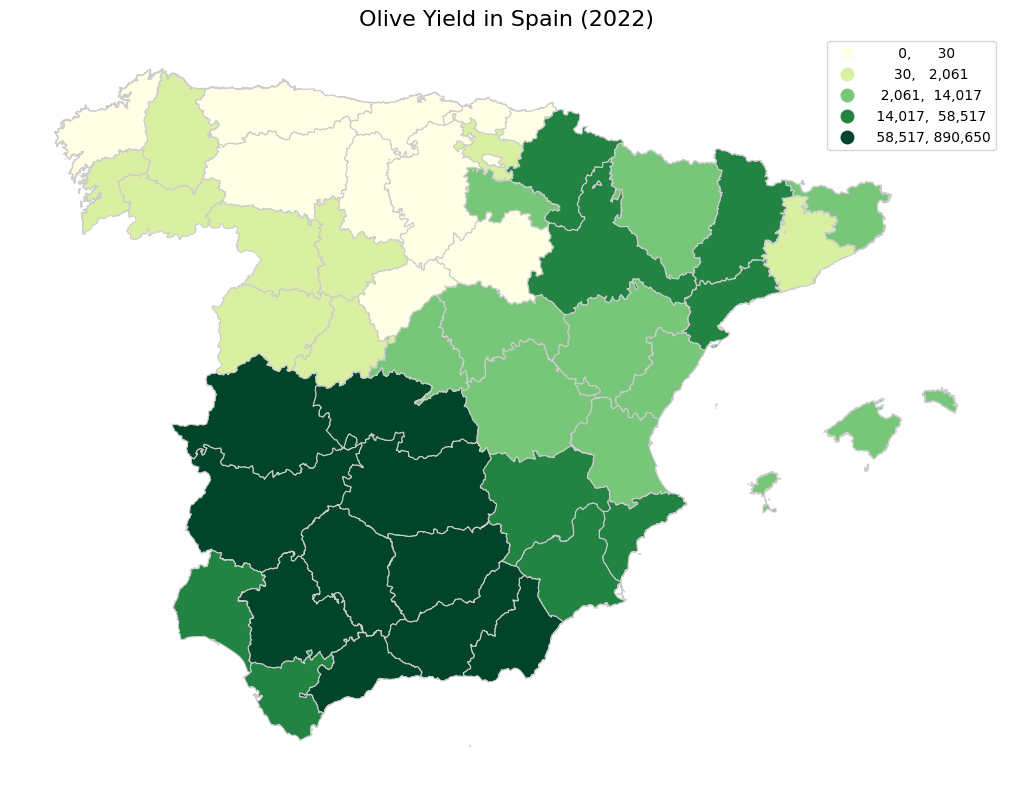

In [12]:
olive_yield_2022 = spain_map.merge(olive_yield_df.query("year == 2022"), on="province")

# Drop Canary Islands to focus on mainland Spain
olive_yield_2022 = olive_yield_2022.query("community != 'Canarias'")

# Handle skewed data using a quantile color scale
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Create choropleth map with a quantile color scale
olive_yield_2022.plot(
    column="total",
    cmap="YlGn",
    linewidth=0.8,
    edgecolor="0.8",
    legend=True,
    scheme="quantiles",  # Use quantiles to handle the skew
    ax=ax,
    legend_kwds={
        "fmt": "{:,.0f}",  # Add commas to the numbers for the legend
    },
)

# Turn off axis for clean map
ax.set_title("Olive Yield in Spain (2022)", fontsize=16)
ax.set_axis_off()

# Adjust layout
plt.tight_layout()

# Display the map
plt.show()

## 4. Yearly Contribution of Top Provinces - Fixed Coloring


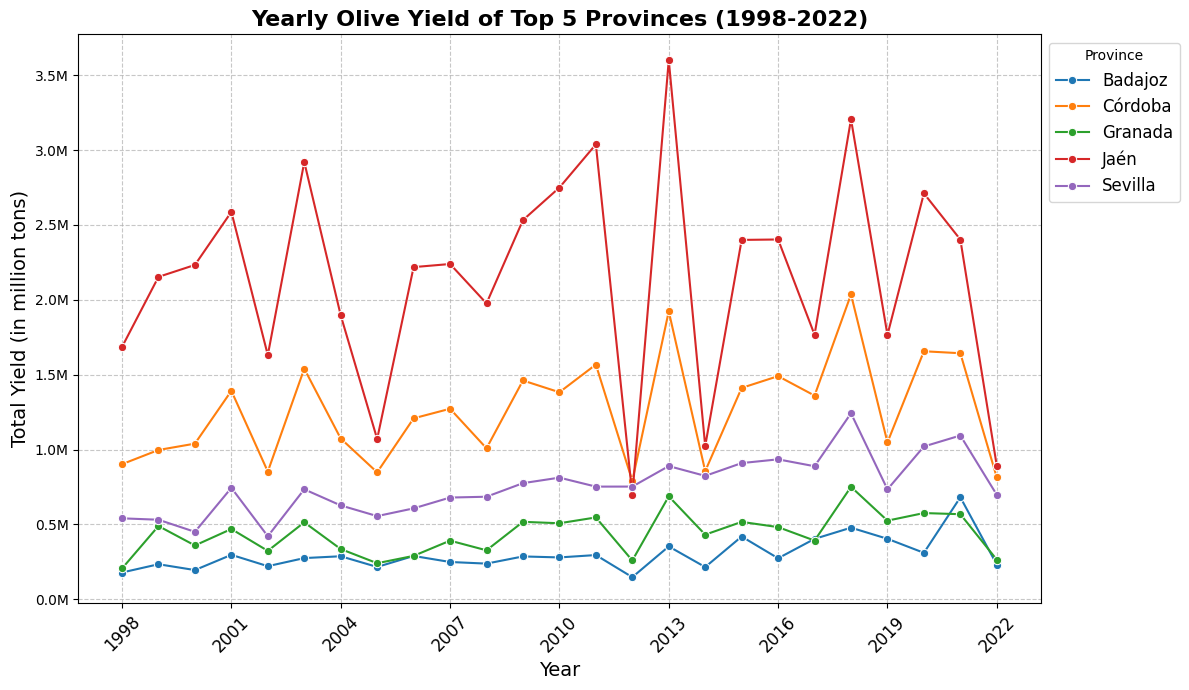

In [13]:
top_provinces_list = [
    "Jaén",
    "Córdoba",
    "Sevilla",
    "Granada",
    "Badajoz",
]

# Set figure size for consistency
plt.figure(figsize=(12, 7))

# Plot the data with a line plot and markers
sns.lineplot(
    x="year",
    y="total",
    hue="province",
    data=olive_yield_df[olive_yield_df["province"].isin(top_provinces_list)],
    marker="o",
    palette="tab10",
)

# Title and axis labels with adjusted font sizes
plt.title(
    "Yearly Olive Yield of Top 5 Provinces (1998-2022)", fontsize=16, weight="bold"
)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Total Yield (in million tons)", fontsize=14)

# Rotate x-axis labels for better readability and ensure all years are displayed
plt.xticks(rotation=45, fontsize=12)
plt.gca().xaxis.set_major_locator(
    plt.MaxNLocator(integer=True)
)  # Ensure every year is displayed

# Format y-axis in millions
plt.gca().yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{x*1e-6:.1f}M")
)

# Add gridlines for better readability
plt.grid(True, linestyle="--", alpha=0.7)

# Adjust the legend and position it out of the plot for clarity
plt.legend(title="Province", loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

# Tight layout to avoid overlapping elements
plt.tight_layout()

# Show the final plot
plt.show()

## 5. Yield by irrigation type:


In [14]:
olive_cultivation_system_new = (
    olive_cultivation_system_df.pipe(
        add_total_production_area,
        "rainfed_production_area",
        "irrigated_production_area",
    )
    .pipe(
        add_production_area_percentage, "total_plantation_area", "total_production_area"
    )
    .pipe(
        add_rainfed_production_area_percentage,
        "rainfed_production_area",
        "total_production_area",
    )
    .pipe(add_rainfed_total_production, "rainfed_production_area", "rainfed_yield")
    .pipe(
        add_irrigated_total_production,
        "irrigated_production_area",
        "irrigated_yield",
    )
)

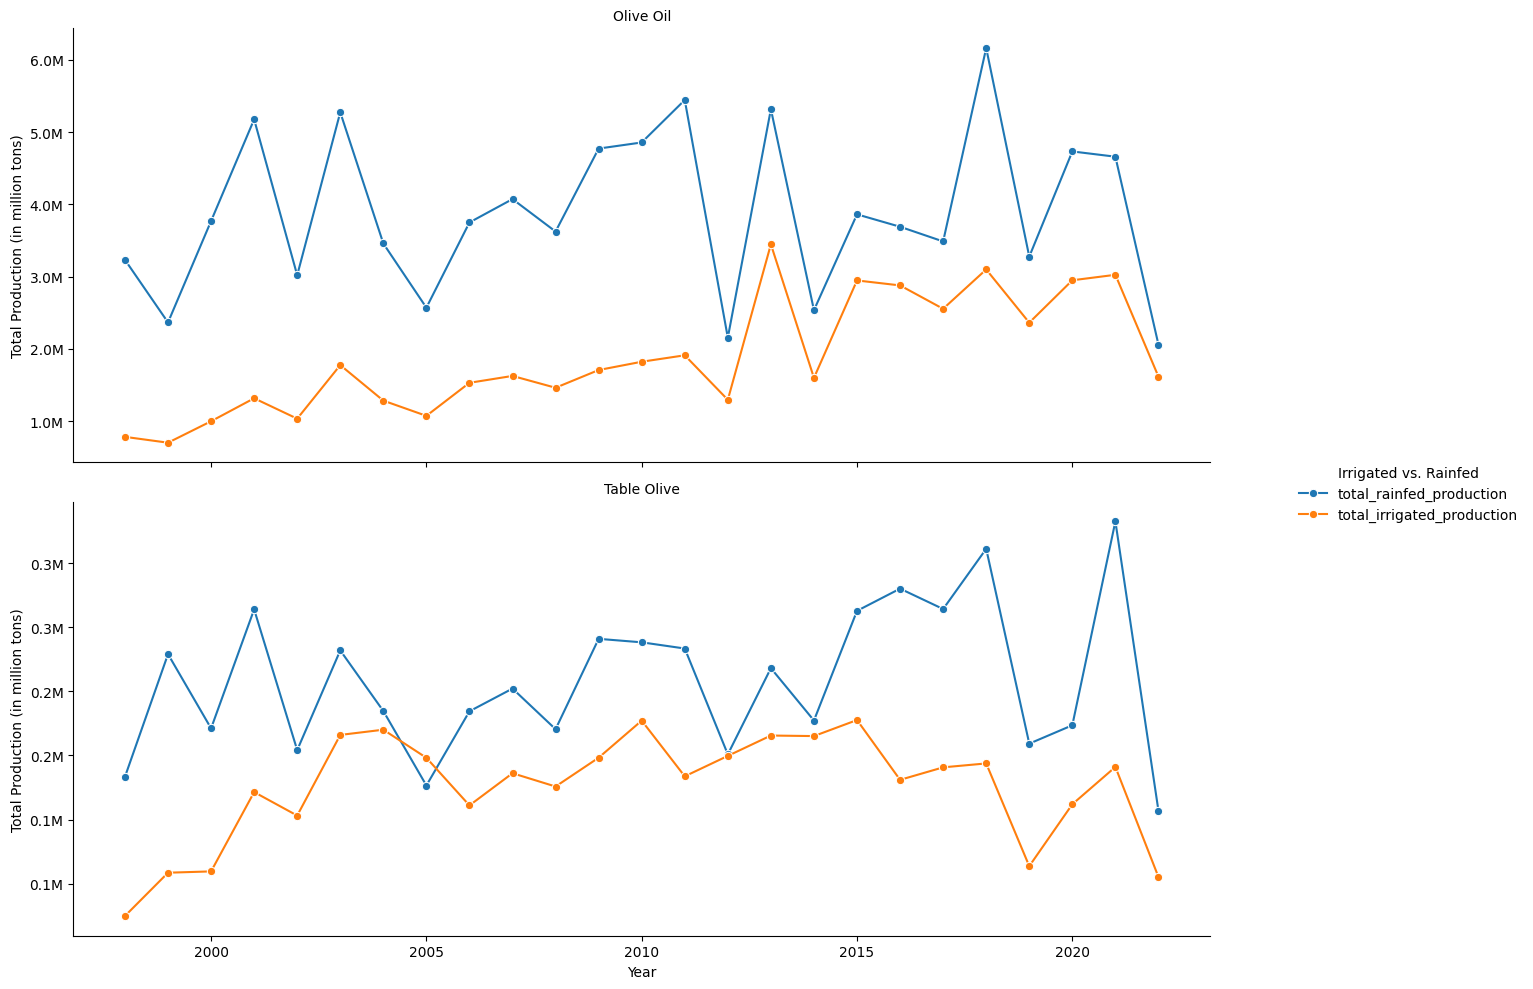

In [15]:
yearly_production_by_system_and_type = (
    olive_cultivation_system_new.loc[
        :,
        [
            "year",
            "province",
            "crop_type",
            "rainfed_total_production",
            "irrigated_total_production",
        ],
    ]
    .assign(
        crop_type=lambda df_: df_["crop_type"].map(
            {"oil": "Olive Oil", "table": "Table Olive"}
        )
    )
    .groupby(by=["year", "crop_type"], as_index=False)
    .agg(
        total_rainfed_production=("rainfed_total_production", "sum"),
        total_irrigated_production=("irrigated_total_production", "sum"),
    )
    .melt(
        id_vars=["year", "crop_type"],
        value_vars=["total_rainfed_production", "total_irrigated_production"],
        var_name="cultivation_system",
        value_name="total_production",
    )
)

g = sns.FacetGrid(
    yearly_production_by_system_and_type,
    row="crop_type",  # Use row to stack plots vertically
    hue="cultivation_system",
    sharey=False,
    height=5,
    aspect=2,  # Increase aspect ratio for better visibility
)

# Plot the data with lineplot and markers
g.map(sns.lineplot, "year", "total_production", marker="o")

# Set axis labels
g.set_axis_labels("Year", "Total Production (in million tons)")

# Set custom titles for each row facet (Olive Oil and Table Olive)
g.set_titles(row_template="{row_name}")

# Add a legend and place it outside the plot
g.add_legend(
    title="Irrigated vs. Rainfed", bbox_to_anchor=(1.05, 0.5), loc="center left"
)

# Format y-axis numbers to display in millions
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x*1e-6:.1f}M"))

# Ensure layout is tight to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

## 6. Yield distribution:


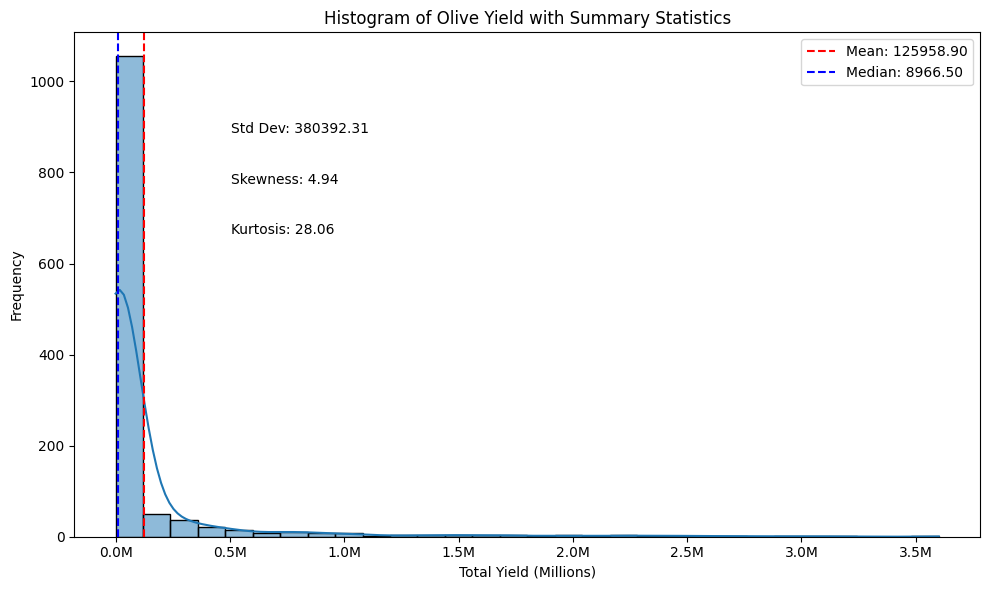

In [16]:
olive_yield_total = olive_yield_df["total"]

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(olive_yield_total, bins=30, kde=True)

# Calculate summary statistics
mean = olive_yield_total.mean()
median = olive_yield_total.median()
std_dev = olive_yield_total.std()
skewness = skew(olive_yield_total)
kurt = kurtosis(olive_yield_total)

# Add vertical lines for mean and median
plt.axvline(mean, color="red", linestyle="--", label=f"Mean: {mean:.2f}")
plt.axvline(median, color="blue", linestyle="--", label=f"Median: {median:.2f}")

# Add text annotations for skewness, kurtosis, and standard deviation
plt.text(mean + std_dev, plt.ylim()[1] * 0.8, f"Std Dev: {std_dev:.2f}", color="black")
plt.text(
    mean + std_dev, plt.ylim()[1] * 0.7, f"Skewness: {skewness:.2f}", color="black"
)
plt.text(mean + std_dev, plt.ylim()[1] * 0.6, f"Kurtosis: {kurt:.2f}", color="black")

# Format the x-axis to display values in millions (or adjust as necessary)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x*1e-6:.1f}M"))

# Customize plot
plt.title("Histogram of Olive Yield with Summary Statistics")
plt.xlabel("Total Yield (Millions)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

## 7. Heatmaps


In [17]:
# List of all Andalucía provinces
andalucia_provinces = ["Jaén", "Córdoba", "Sevilla", "Granada", "Málaga", "Almería"]


# Function to clean data (handling NaN values)
def clean_data(df, method="ffill"):
    """Handle NaN values in the DataFrame."""
    if method == "ffill":
        return df.fillna(method="ffill").fillna(method="bfill")  # Forward/backward fill
    elif method == "drop":
        return df.dropna()
    else:
        raise ValueError("Invalid method for handling NaN values.")


# Function to calculate seasonal statistics using the explicitly passed climate variables
def calculate_seasonal_stats(df, season_months, climate_variables):
    """Aggregate climate data during a specific season (flowering/harvesting) using the provided variables."""
    seasonal_data = df[df["Month"].isin(season_months)]

    # Ensure the selected climate variables are numeric and convert them if necessary
    for col in climate_variables:
        seasonal_data[col] = pd.to_numeric(seasonal_data[col], errors="coerce")

    # Perform the aggregation for only the provided climate variables
    aggregated_data = seasonal_data.groupby(["Year", "province"], as_index=False).agg(
        {
            col: "mean" if "precipitation" not in col else "sum"
            for col in climate_variables
        }
    )

    return aggregated_data


# Function to merge seasonal climate data with olive yield data and apply suffixes correctly
def merge_climate_yield(olive_yield_df, flowering_data, harvesting_data):
    """Merge the seasonal climate data (flowering and harvesting) with olive yield data using correct suffixes."""
    # Merge flowering data with suffix _Flowering
    flowering_olive_data = pd.merge(
        olive_yield_df,
        flowering_data,
        left_on=["year", "province"],
        right_on=["Year", "province"],
        how="left",
        suffixes=("", "_Flowering"),
    ).drop(
        columns=["year", "province", "table_olive", "olive_oil", "Year"],
    )

    # Merge harvesting data with suffix _Harvesting
    harvesting_olive_data = pd.merge(
        olive_yield_df,
        harvesting_data,
        left_on=["year", "province"],
        right_on=["Year", "province"],
        how="left",
        suffixes=("", "_Harvesting"),
    ).drop(
        columns=["year", "province", "table_olive", "olive_oil", "Year"],
    )

    return flowering_olive_data, harvesting_olive_data


# Function to create heatmap
def create_heatmap(df, title):
    """Generate and display a heatmap of the correlation matrix."""
    correlation_matrix = df.corr()
    mask = np.triu(
        np.ones_like(correlation_matrix, dtype=bool)
    )  # Mask the upper triangle
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        vmin=-1,
        vmax=1,
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Main function to run the analysis
def run_analysis(climate_df, olive_yield_df, climate_variables, variables_source_name):
    """Run the analysis on TerraClimate, AEMET, or vegetation health datasets using the provided climate variables."""

    # Step 1: Clean the data (handle NaN values)
    climate_df = clean_data(climate_df, method="ffill")

    # Step 2: Extract Year and Month from the date column
    if "Year" in climate_df.columns:
        climate_df = climate_df.drop(columns=["Year"])  # Remove existing 'Year' column
    climate_df["Year"] = pd.to_datetime(climate_df["date"]).dt.year
    climate_df["Month"] = pd.to_datetime(climate_df["date"]).dt.month

    # Step 3: Filter the data to only include Andalucía provinces
    climate_df = climate_df[climate_df["province"].isin(andalucia_provinces)]

    # Step 4: Define flowering and harvesting months
    flowering_months = [4, 5, 6]
    harvesting_months = [10, 11, 12]

    # Step 5: Calculate seasonal statistics for flowering and harvesting using the passed climate variables
    flowering_climate = calculate_seasonal_stats(
        climate_df, flowering_months, climate_variables
    )
    harvesting_climate = calculate_seasonal_stats(
        climate_df, harvesting_months, climate_variables
    )

    # Step 6: Merge seasonal data with olive yield data
    olive_yield_df["year"] = olive_yield_df["year"].astype(int)

    flowering_data, harvesting_data = merge_climate_yield(
        olive_yield_df, flowering_climate, harvesting_climate
    )

    create_heatmap(
        flowering_data,
        f"Correlation Between Olive Yield and {variables_source_name} Climate Variables\nDuring Flowering Season for Andalucía Provinces",
    )
    create_heatmap(
        harvesting_data,
        f"Correlation Between Olive Yield and {variables_source_name} Climate Variables\nDuring Harvesting Season for Andalucía Provinces",
    )

In [18]:
terra_climate_columns = [
    "actual_evapotranspiration",
    "max_temperature",
    "min_temperature",
    "potential_evapotranspiration",
    "precipitation",
    "soil_moisture",
    "water_balance",
    "SPEI_1M",
    "SPEI_3M",
    "SPEI_6M",
    "SPEI_9M",
    "SPEI_12M",
    "SPEI_24M",
    "SPI_1M",
    "SPI_3M",
    "SPI_6M",
    "SPI_9M",
    "SPI_12M",
    "SPI_24M",
]

aemet_columns = [
    "temperature_average",
    "temperature_min",
    "temperature_max",
    "precipitation",
    "wind_speed_average",
    "solar_radiation",
    "pressure_max",
    "pressure_min",
    "humidity_average",
    "humidity_max",
    "humidity_min",
]

C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill").fillna(method="bfill")  # Forward/backward fill
C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data[col] = pd.to_numeric(seasonal_data[col], errors="coerce")
C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

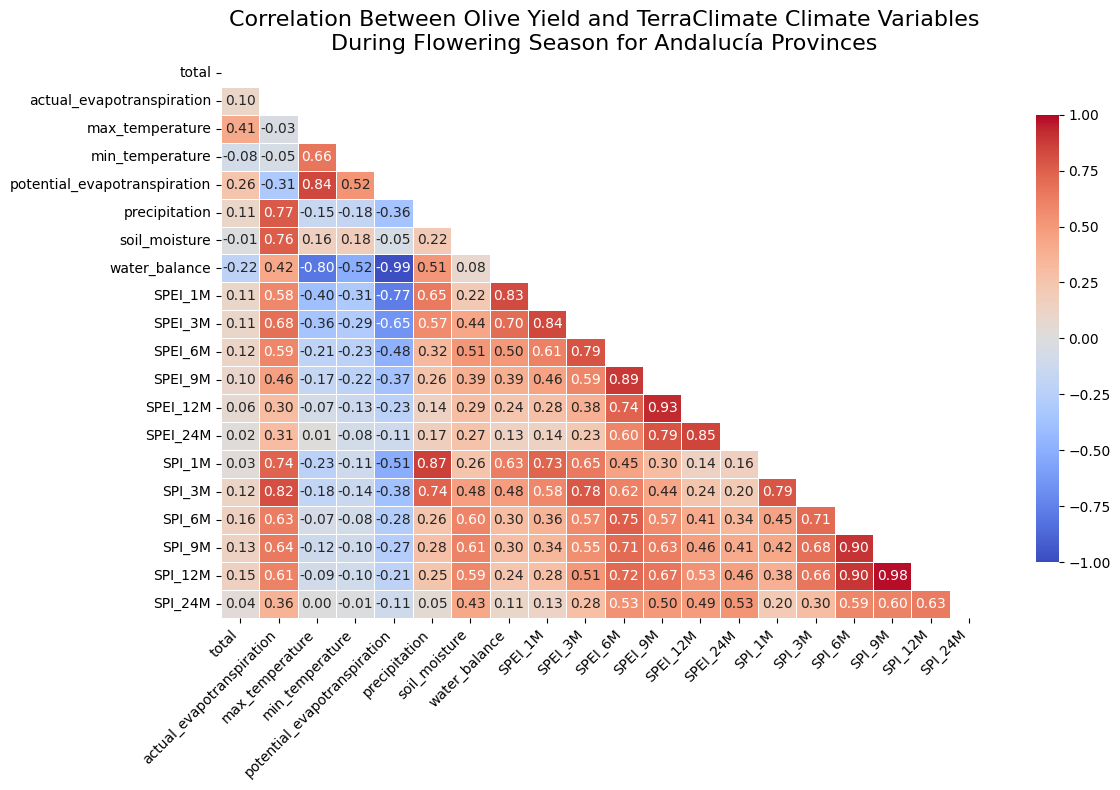

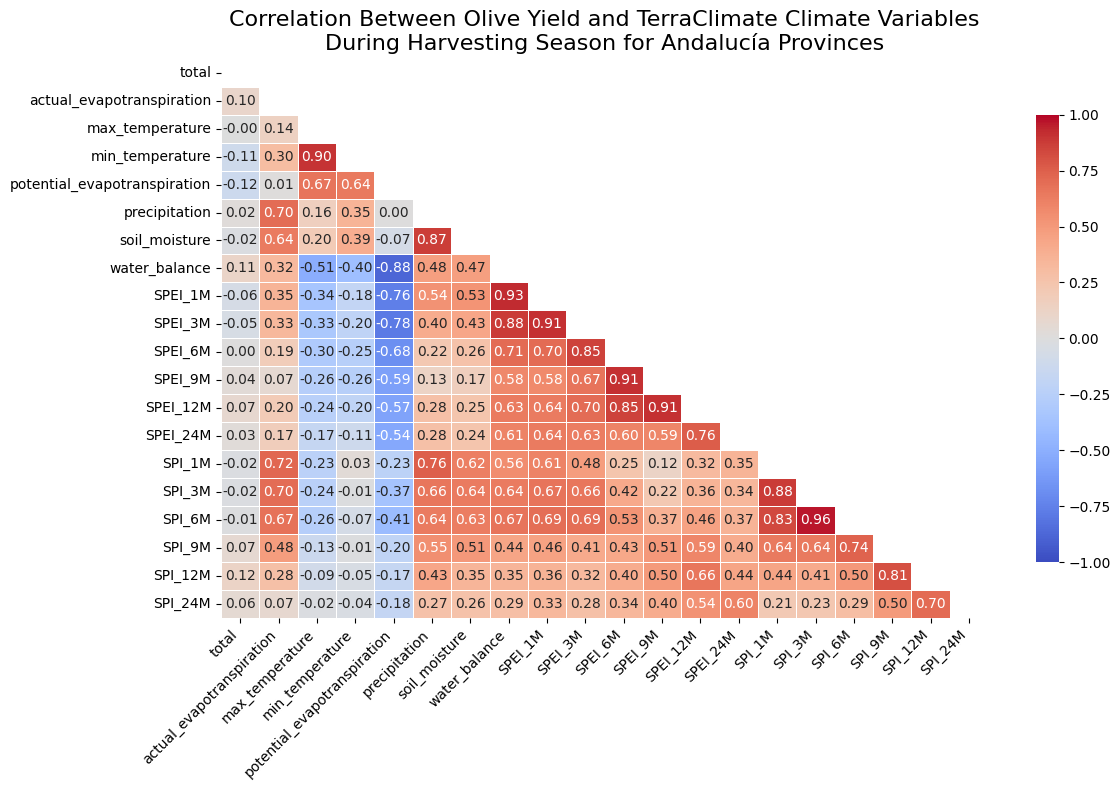

In [19]:
run_analysis(terra_climate_df, olive_yield_df, terra_climate_columns, "TerraClimate")

C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return df.fillna(method="ffill").fillna(method="bfill")  # Forward/backward fill
C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seasonal_data[col] = pd.to_numeric(seasonal_data[col], errors="coerce")
C:\Users\Reslan Al Tinawi\AppData\Local\Temp\ipykernel_1892\471016094.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

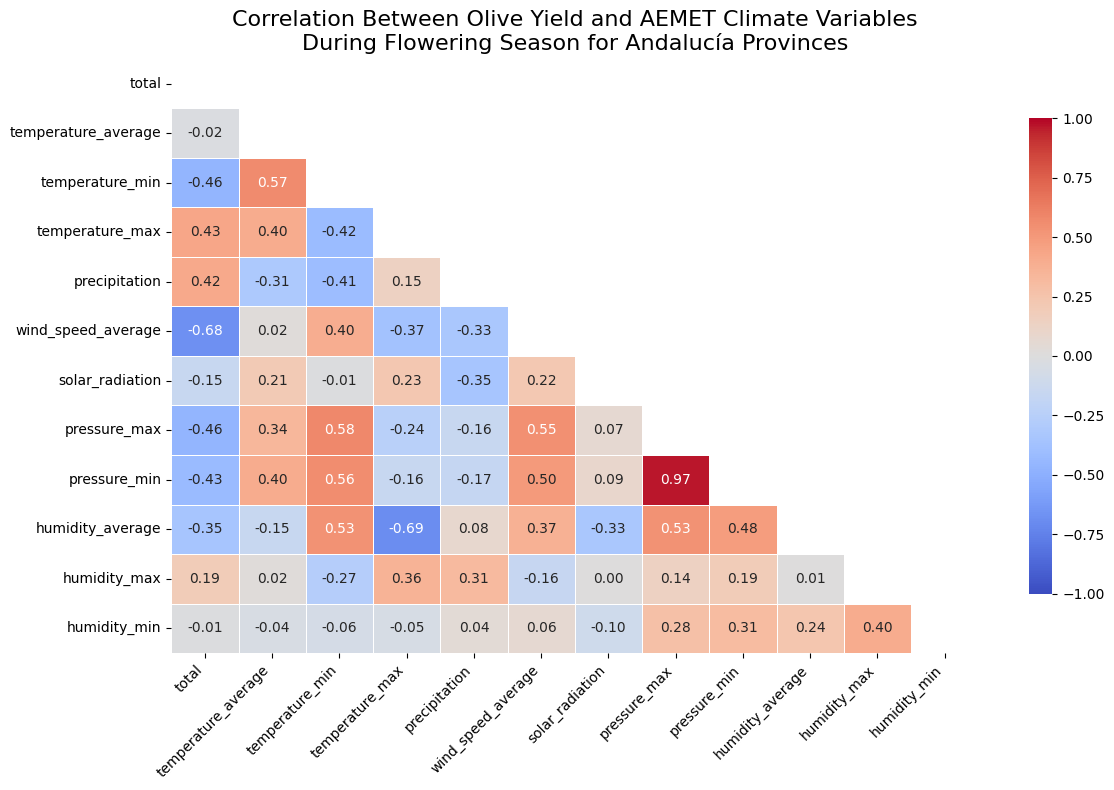

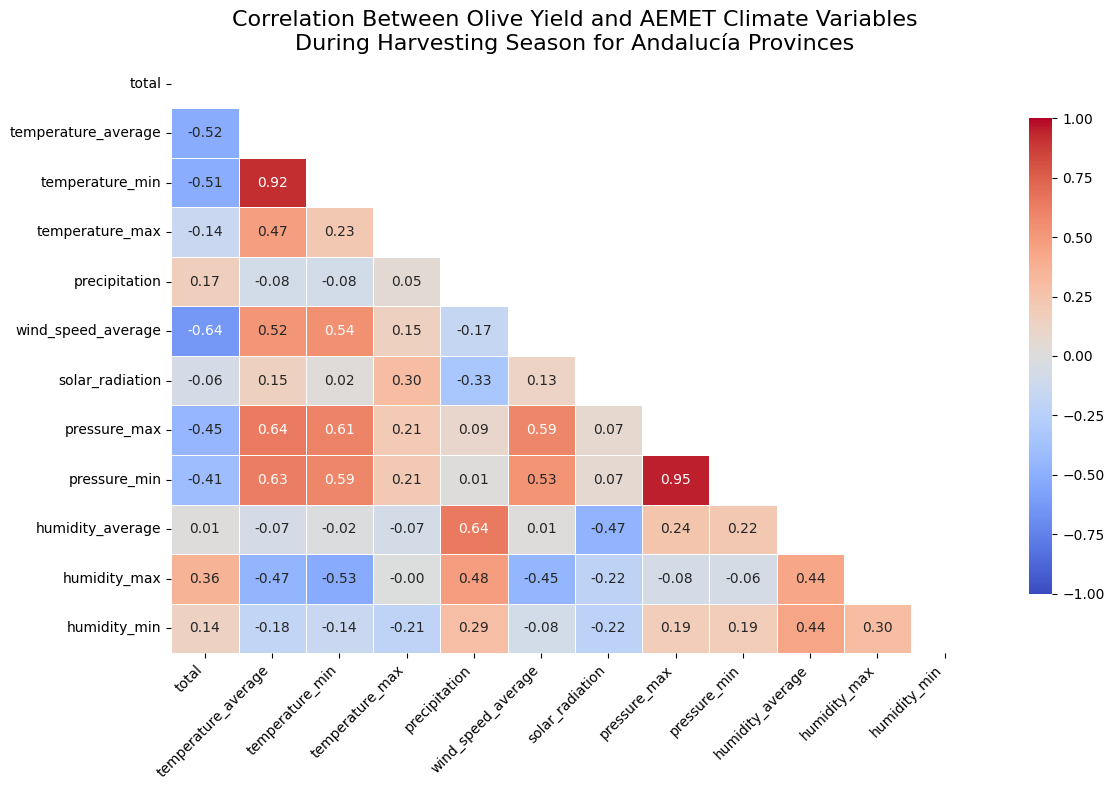

In [20]:
run_analysis(aemet_monthly_df, olive_yield_df, aemet_columns, "AEMET")

## 8. Calendar plot


In [21]:
def create_year_month_pivot(df, province_name, date_column, feature_name):
    months_order = [
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]

    province_df = df[df["province"] == province_name]

    # Create 'year' and 'month_name' columns

    province_df = province_df.assign(
        year=province_df[date_column].dt.year,
        month_name=pd.Categorical(
            province_df[date_column].dt.month_name(),
            categories=months_order,
            ordered=True,
        ),
    )

    # Pivot the dataframe to get years as rows and months as columns
    pivot_df = province_df.pivot(
        index="year", columns="month_name", values=feature_name
    )

    return pivot_df

In [22]:
def plot_calendar_heatmap(pivot_df, cmap="Blues", cbar_label=None, title=None):
    # Dynamically calculate vmin and vmax
    vmin = pivot_df.min().min()  # Minimum value in the pivot table
    vmax = pivot_df.max().max()  # Maximum value in the pivot table

    plt.figure(figsize=(14, 10))

    # Create heatmap
    sns.heatmap(
        pivot_df,
        annot=True,  # Show the value annotations in the heatmap
        fmt=".2f",  # Format of the annotations
        cmap=cmap,  # Color map to use
        linewidths=0.5,  # Lines between cells
        linecolor="black",  # Color of the lines between cells
        cbar_kws={"label": cbar_label},  # Colorbar label
        vmin=vmin,  # Automatically calculated minimum value
        vmax=vmax,  # Automatically calculated maximum value
    )

    # Set titles and labels
    plt.title(title)
    plt.xlabel("Month")
    plt.ylabel("Year")

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

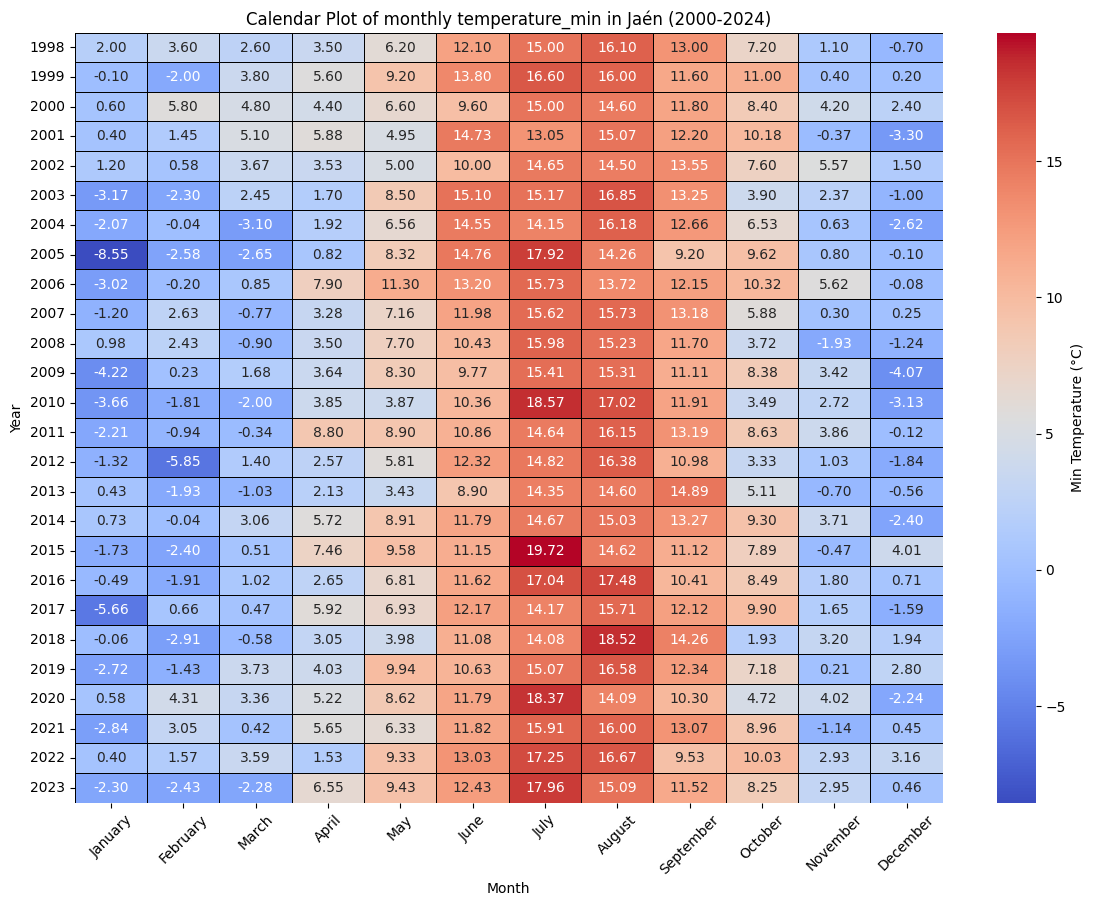

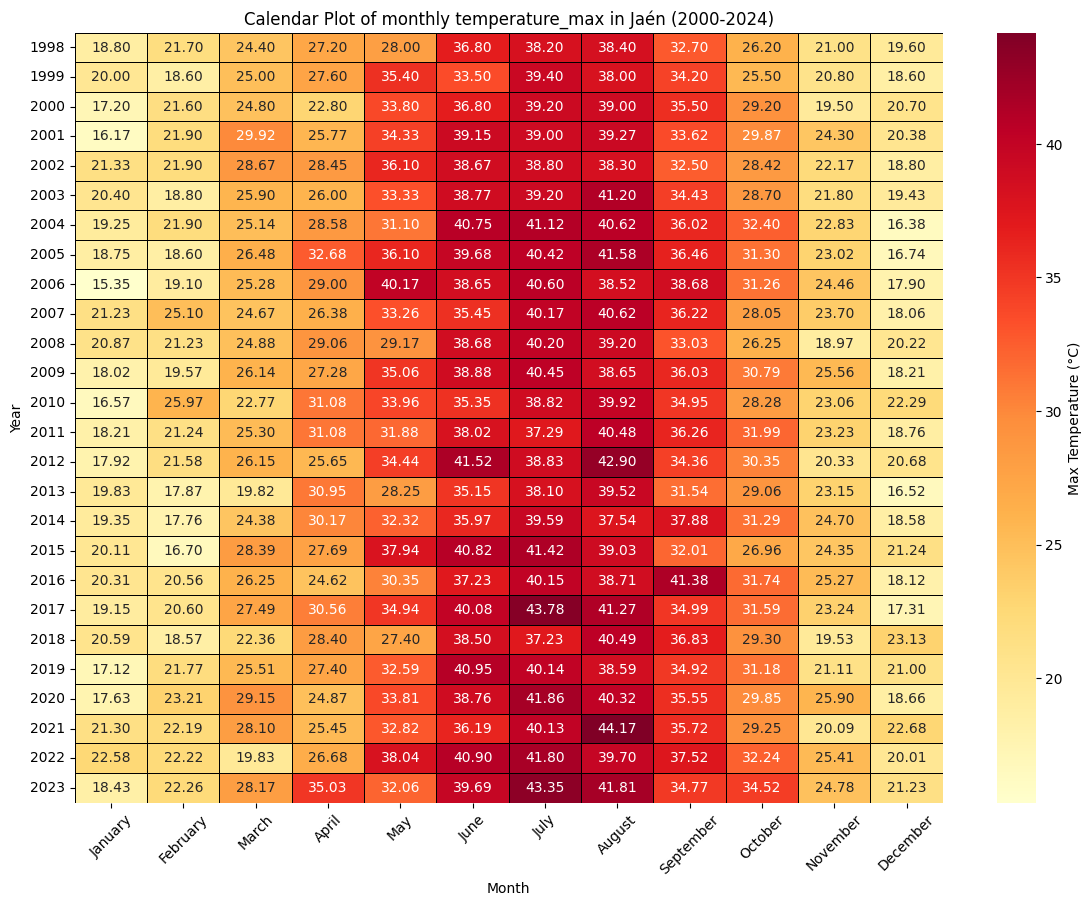

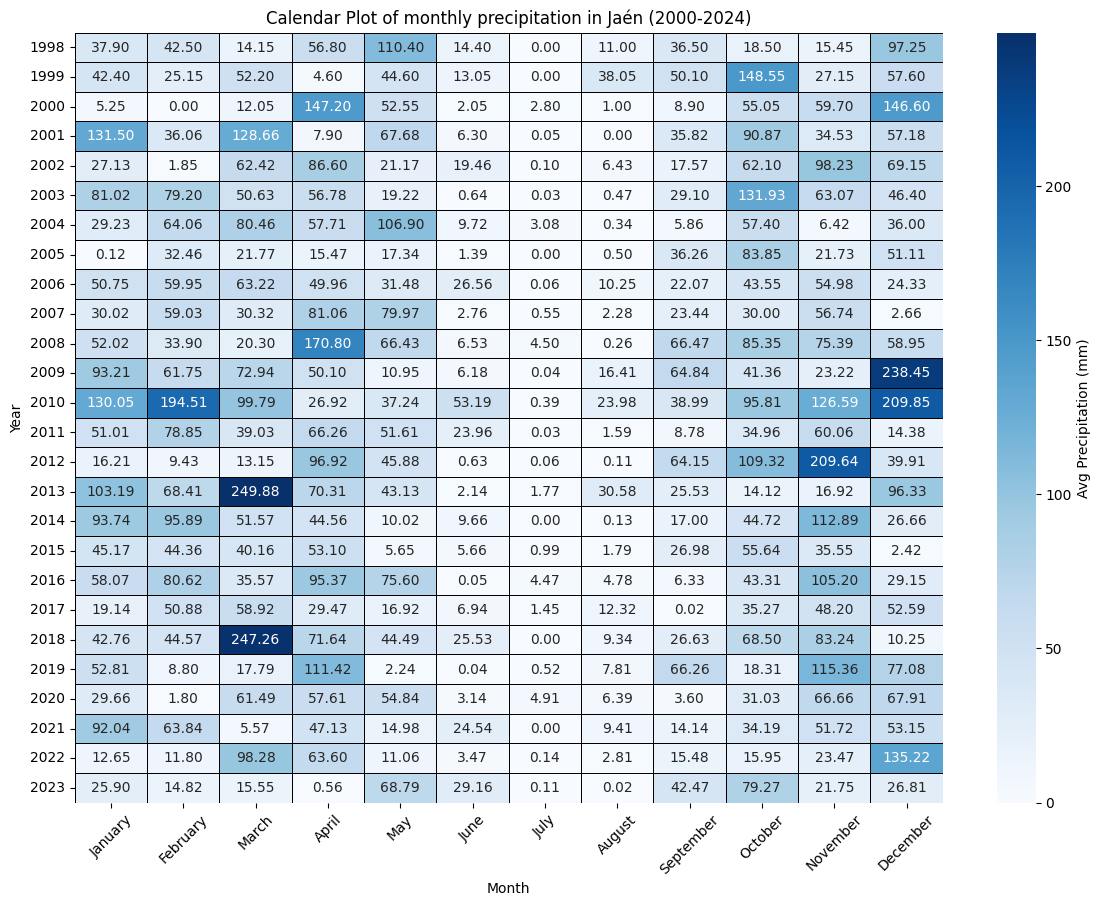

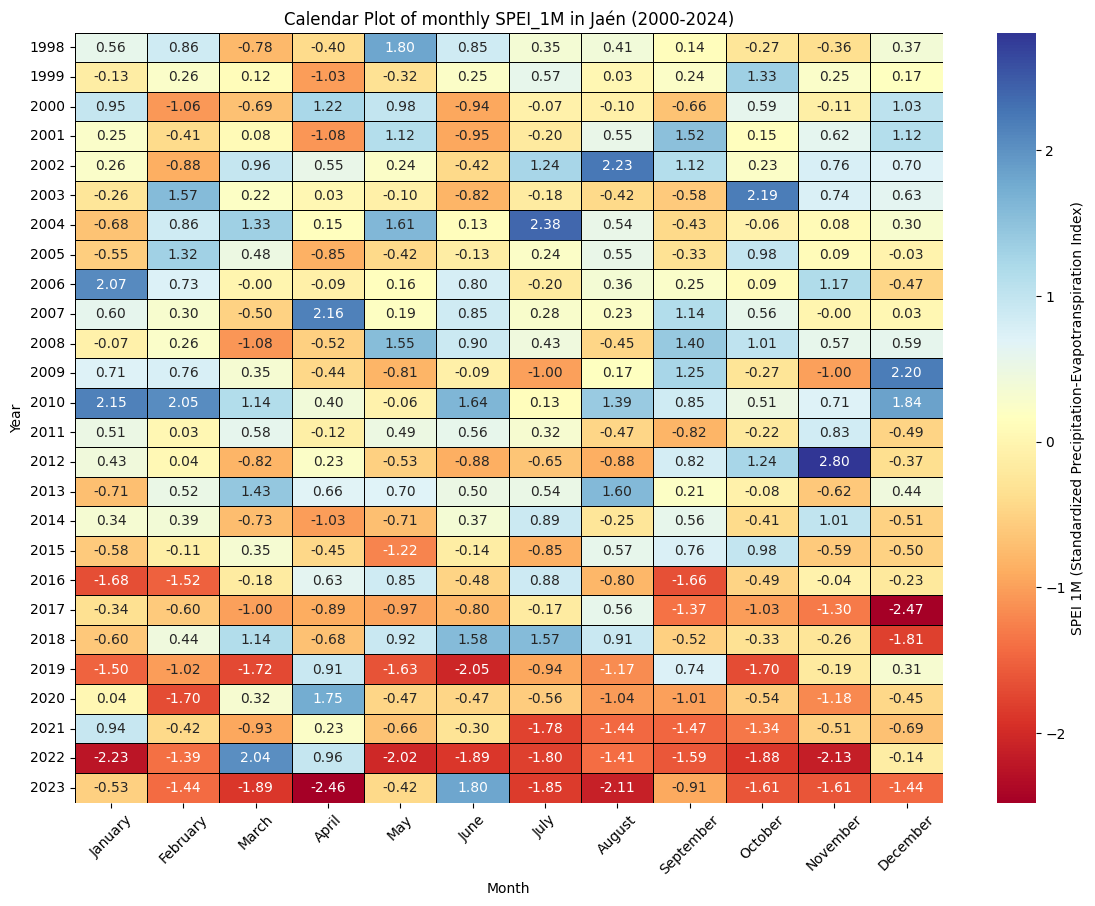

In [23]:
selected_features = [
    "temperature_min",
    "temperature_max",
    "precipitation",
    "SPEI_1M",
]

# Color maps corresponding to the selected features
color_maps = {
    "temperature_min": "coolwarm",
    "temperature_max": "YlOrRd",
    "precipitation": "Blues",
    "SPEI_1M": "RdYlBu",
}

# Labels for colorbars
cbar_labels = {
    "temperature_min": "Min Temperature (°C)",
    "temperature_max": "Max Temperature (°C)",
    "precipitation": "Avg Precipitation (mm)",
    "SPEI_1M": "SPEI 1M (Standardized Precipitation-Evapotranspiration Index)",
}

# Data sources for AEMET and TerraClimate
dataframes = {
    "temperature_min": aemet_monthly_df,
    "temperature_max": aemet_monthly_df,
    "precipitation": aemet_monthly_df,
    "SPEI_1M": terra_climate_df,  # SPEI_1M from TerraClimate
}

# Loop through the selected features and generate the calendar plots
for feature in selected_features:
    # Select the correct dataframe
    df = dataframes[feature]

    # Create pivoted dataframe for each feature (filtered by province Jaén)
    pivot_df = create_year_month_pivot(
        df, province_name="Jaén", date_column="date", feature_name=feature
    )

    # Plot the calendar heatmap
    plot_calendar_heatmap(
        pivot_df,
        cmap=color_maps[feature],  # Use the corresponding colormap
        cbar_label=cbar_labels[feature],  # Use the corresponding colorbar label
        title=f"Calendar Plot of monthly {feature} in Jaén (2000-2024)",
    )